# Analysis and curation of [cxr14](https://nihcc.app.box.com/v/ChestXray-NIHCC) dataset

The dataset consists of x-ray images of patients and the labels are the conditions that are present on the patient.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from PIL import Image

In [2]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation',
          'No Finding']
labels.sort()
print(labels)

#read the whole dataset
df = pd.read_csv("dataset/Data_Entry_2017_v2020.csv")

df_count = (df.groupby('Patient ID')
         .agg({'Patient ID' : 'count'})
         .rename(columns={'Patient ID':'count'}))

print('Total entries:',len(df.index))
print('No of patients:',df_count.query('count > 1').shape[0])
df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Total entries: 112120
No of patients: 13302


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


There are 112120 total x-ray entries of 13302 patients
We observe that there exists only a single label where the conditions are words delimited with a character (|). If we try to find the unique disease combinations we get alot of them.

Number of disease combinations : 836
                                                    count
No Finding                                          60361
Infiltration                                         9547
Atelectasis                                          4215
Effusion                                             3955
Nodule                                               2705
...                                                   ...
Atelectasis|Consolidation|Edema|Effusion|Infilt...      1
Atelectasis|Consolidation|Effusion|Emphysema|Ma...      1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumo...      1
Edema|Infiltration|Pneumothorax                         1
Atelectasis|Consolidation|Mass|Pleural_Thickeni...      1

[836 rows x 1 columns]


[]

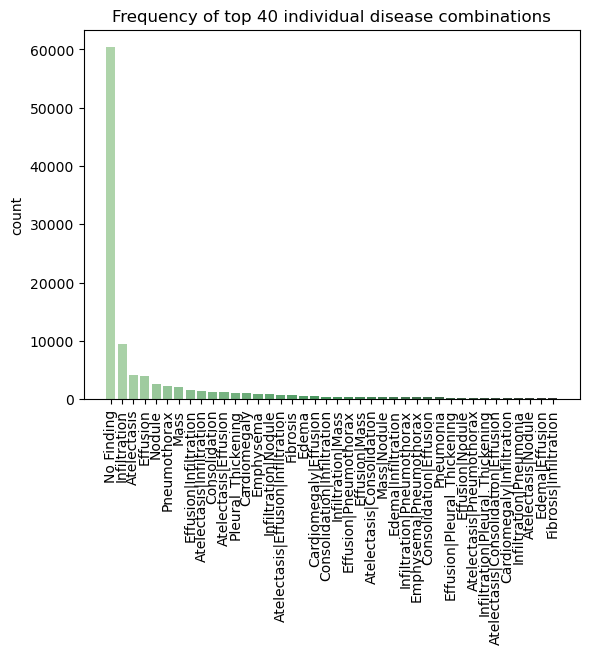

In [3]:
counts = df['Finding Labels'].value_counts().to_frame(name = 'count')
disease_combinations = len(counts.index)
print('Number of disease combinations :', disease_combinations)

print(counts)
sns.barplot(x = counts.index[:40], y='count', data=counts[:40], palette="Greens_d")
plt.xticks(rotation = 90)
plt.title('Frequency of top 40 individual disease combinations')
plt.plot()

This representation is not easy to work with. We will have to transform this to one column per label when we will actually use the dataset.

In [4]:
for label in labels:
    df[label] = df['Finding Labels'].map(lambda res: 1 if label in res else 0)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0


We can now plot the frequency graph of each individual disease:


                    count
No Finding          60361
Infiltration        19894
Effusion            13317
Atelectasis         11559
Nodule               6331
Mass                 5782
Pneumothorax         5302
Consolidation        4667
Pleural_Thickening   3385
Cardiomegaly         2776
Emphysema            2516
Edema                2303
Fibrosis             1686
Pneumonia            1431
Hernia                227


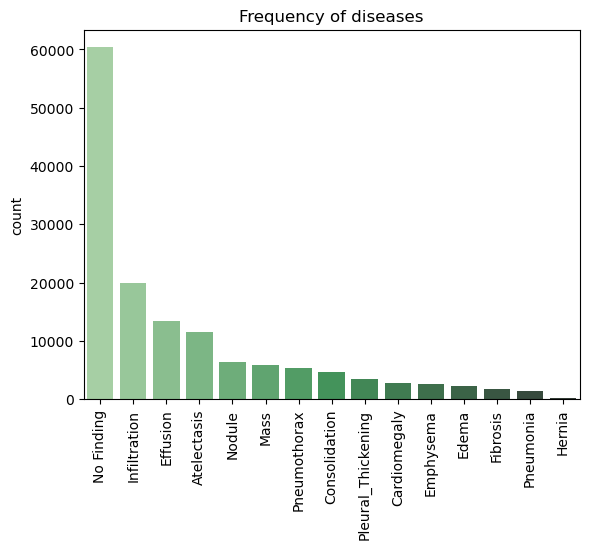

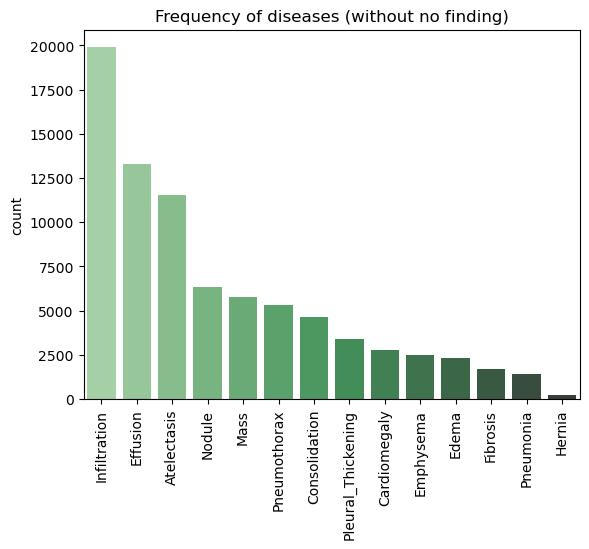

In [5]:
label_count = df[labels].sum().to_frame('count').sort_values(['count'], ascending=False)
print(label_count)

sns.barplot(x = label_count.index, y='count', data=label_count, palette="Greens_d")
plt.xticks(rotation = 90)
plt.title('Frequency of diseases')
plt.show()
sns.barplot(x = label_count.index.drop('No Finding'), y='count', data=label_count.drop('No Finding'), palette="Greens_d")
plt.xticks(rotation = 90)
plt.title('Frequency of diseases (without no finding)')
plt.show()


We observe that Infiltration, Effusion and Atelectasis are the conditions that occur the most. Moreover a substatial amount of x-rays depict people that don't have any of the conditions. To get a better look we will plot the same graphs but with a percentage of the total entries:

Infiltration is ~20%, Effusion and Atelectasis ~10% and a stagering ~50% of the xrays depict no condition

Now let's explore the non image features of the dataset.


Age distribution

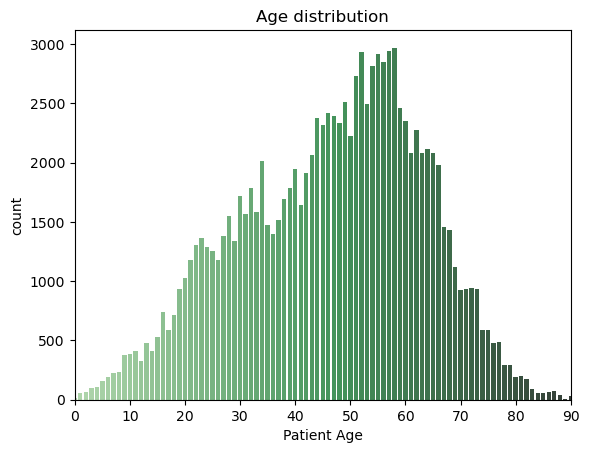

In [6]:
plot = sns.countplot(x='Patient Age',data=df, palette="Greens_d")
plot.set_xlim(0,90)
plot.set(title='Age distribution')
x = np.arange(0,100,10)
plot.set_xticks(x)
plot.set_xticklabels(x)
plt.show()

Gender distribution

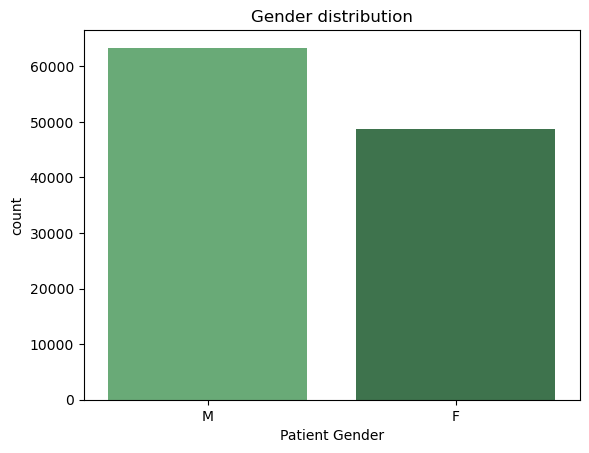

In [7]:
plot = sns.countplot(x='Patient Gender',data=df, palette="Greens_d")
plot.set(title='Gender distribution')
plt.show()

We can also plot the age as it correlates to the gender:

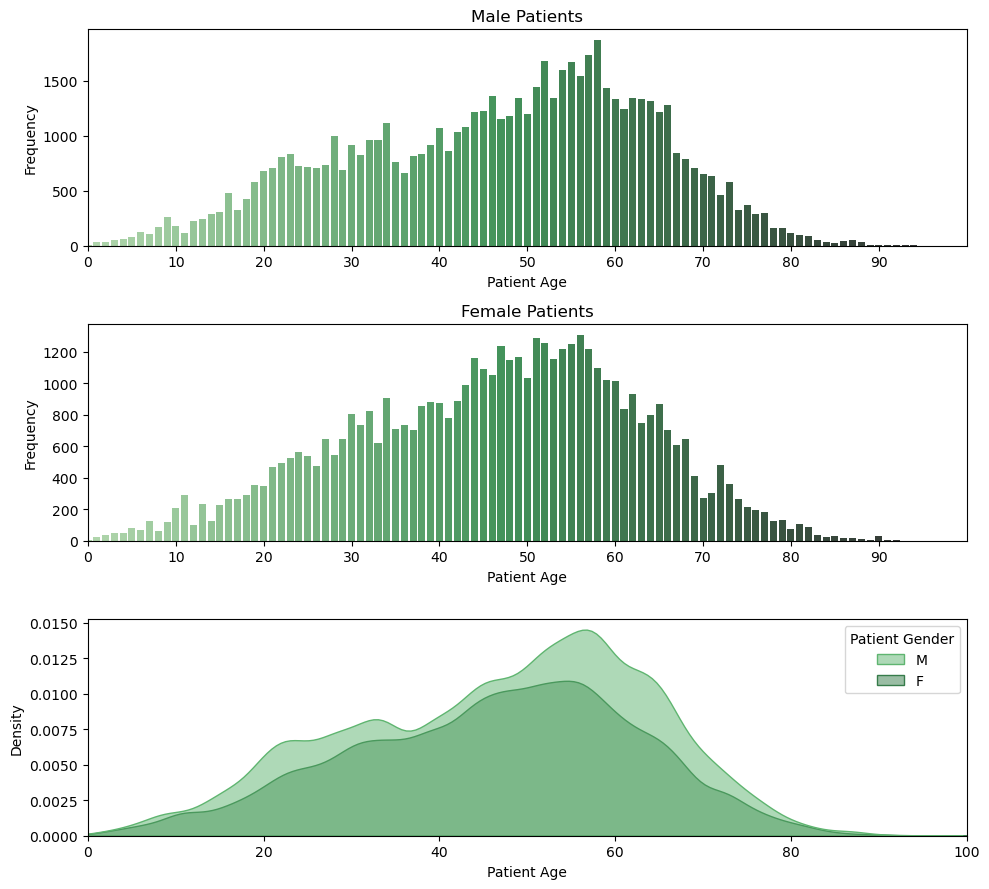

In [8]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 9))
x = np.arange(0,100,10)
sns.countplot(data=df[df['Patient Gender'] == 'M'], x='Patient Age', ax=axs[0], palette="Greens_d")
axs[0].set_title('Male Patients')
axs[0].set_xlabel('Patient Age')
axs[0].set_ylabel('Frequency')
axs[0].set_xticks(x)
axs[0].set_xlim(0,100)
sns.countplot(data=df[df['Patient Gender'] == 'F'], x='Patient Age', ax=axs[1], palette="Greens_d")
axs[1].set_title('Female Patients')
axs[1].set_xlabel('Patient Age')
axs[1].set_ylabel('Frequency')
axs[1].set_xticks(x)
axs[1].set_xlim(0,100)


axs[2] = sns.kdeplot(data=df, x='Patient Age', hue='Patient Gender', fill=True, alpha=0.5, common_norm=True, palette="Greens_d")
axs[2].set_xlim(0,100)
plt.tight_layout()
plt.show()



There are 2 view positions possible anterior to posterior (AP) and posterior to anterior (PA). Their numbers are shown in the following graph.

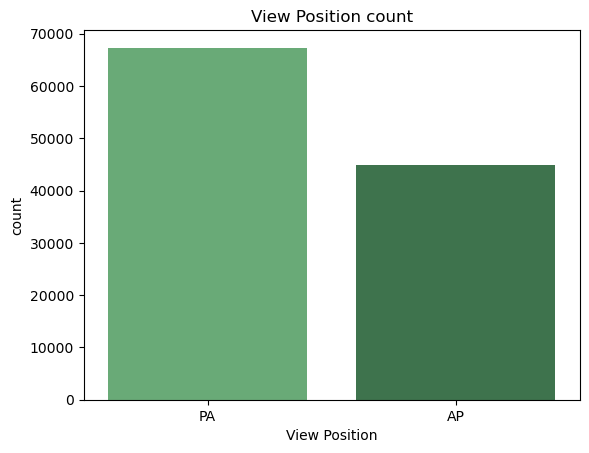

In [9]:
plot = sns.countplot(x='View Position',data=df, palette="Greens_d")
plot.set(title='View Position count')
plt.show()

Some patients tend to have follow ups. We observe that most patient either have zero or up to 10 follow ups. The number falls dramatically afterwards.

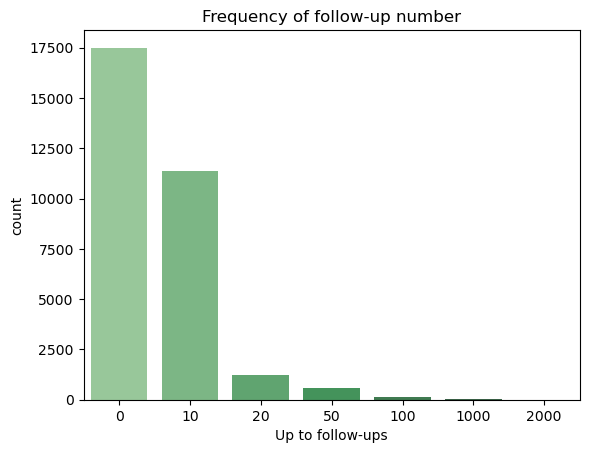

In [10]:

max_per_patient = df.groupby('Patient ID')['Follow-up #'].max().to_frame('max')
count_of_num_of_followups = max_per_patient['max'].value_counts(bins=[-0.001, 0.1 ,10, 20 ,50,100, 1000, 2000], sort=False).to_frame(name = 'count')
count_of_num_of_followups.index = count_of_num_of_followups.index.map(lambda i: int(i.right))

plot = sns.barplot(x = count_of_num_of_followups.index, y='count', data = count_of_num_of_followups, palette="Greens_d")
plot.set_title('Frequency of follow-up number')
plot.set_xlabel('Up to follow-ups')
plt.show()

Finally let us sample some random xrays from the dataset:

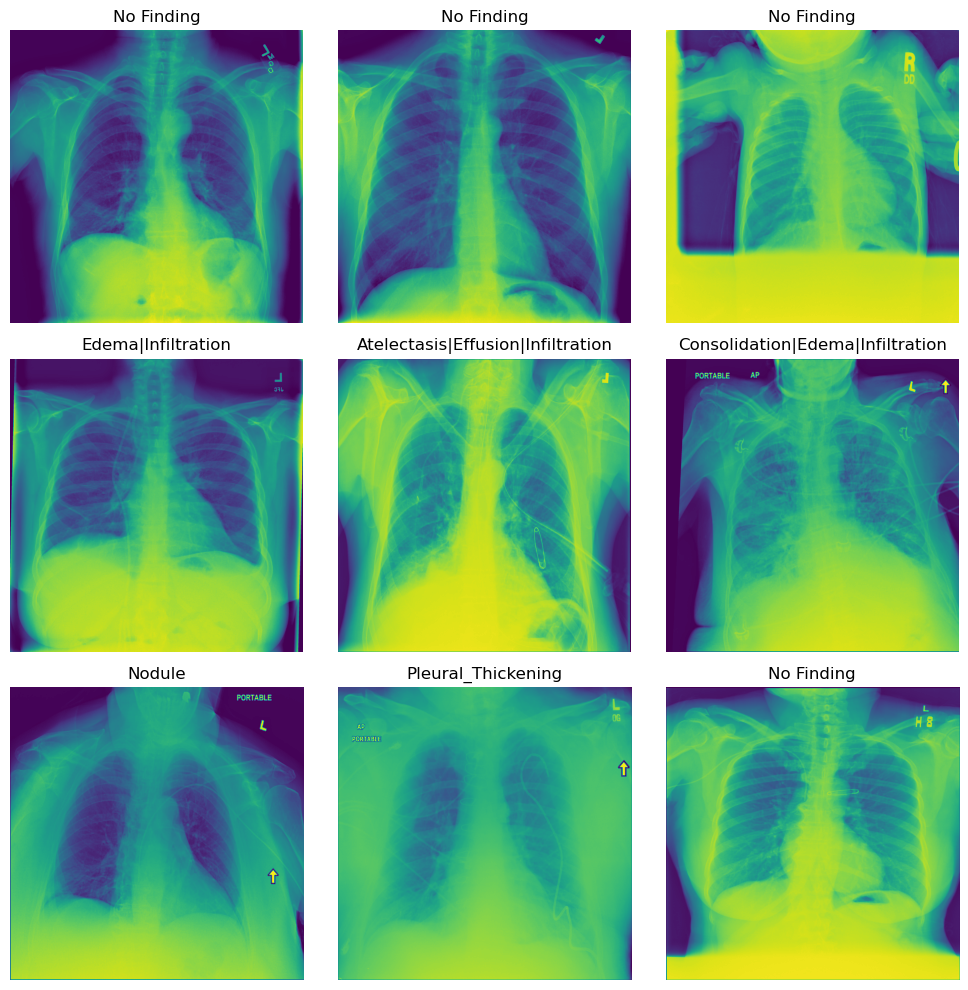

In [11]:
sample = df.sample(9)
graph_labels = sample['Finding Labels']
fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = axes.flatten()
images = sample['Image Index'].map(lambda name: Image.open('dataset/images/'+name))
for img, ax, label in zip(images, axes, graph_labels):
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()